In [1]:
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Get raw files for imputation 

### Get tcga genotypes imputed from only WXS genotypes

In [7]:
directory="/cellar/users/mpagadal/Data2/projects/germline-immune/disease-relevance/associations/icb-genotypes/new-tcga/"
files = [x for x in os.listdir(directory) if "raw" in x]

new_tcga=pd.read_csv(directory+files[0],delim_whitespace=True)

for x in files[1:]:
    raw=pd.read_csv(directory+x,delim_whitespace=True)
    new_tcga=pd.merge(new_tcga, raw, on=["FID","IID","PAT","MAT","SEX","PHENOTYPE"])

### Get tcga genotypes imputed from Affymetrix 6.0 array

In [9]:
old_tcga=pd.read_csv("/cellar/users/mpagadal/Data2/projects/germline-immune/disease-relevance/associations/icb-genotypes/original-tcga/tcga.raw",delim_whitespace=True)
snps=old_tcga.columns[6:].tolist()

### Check to see if all genotypes are available

In [10]:
snps_test=[]

for x in snps:
    try:
        new_tcga[x]
        snps_test.append(x)
    except:
        snp=x.rsplit(":",2)[0]
        minor=x.split("_")[-1]
        try:
            new_x=[x for x in new_tcga.columns if snp in x][0]
            snps_test.append(x)
        except:
            print("missing {}".format(snp))
        if new_x.split("_")[-1]==minor:
            new_tcga[x]=new_tcga[new_x]
        else:
            print(x)
            print(new_x)
            new_tcga[x]=new_tcga[new_x].map({2:0,1:1,0:2})

6:31298890:C:T_T
6:31298890:C:T_C
6:32169621:A:T_T
6:32169621:T:A_A


In [12]:
len(snps_test)

580

### Merge WXS and Affymetrix calls

In [13]:
old_tcga.columns=old_tcga.columns.tolist()[0:6]+["org "+x for x in old_tcga.columns.tolist()[6:]]
new_tcga.columns=new_tcga.columns.tolist()[0:6]+["new "+x for x in new_tcga.columns.tolist()[6:]]

In [15]:
all_tcga=pd.merge(old_tcga,new_tcga,on=new_tcga.columns.tolist()[0],how="left")

### Calculate mismatch frequency

In [16]:
snps=[]
mismatch=[]

for x in snps_test:
    snps.append(x)
    mismatch.append(len(all_tcga[all_tcga["org "+x]!=all_tcga["new "+x]])/len(all_tcga))

In [17]:
df=pd.DataFrame({"snps":snps,"impute mismatch":mismatch})
df["snps"]=df["snps"].str.split("_").str[0]

In [18]:
#map to minor allele frequency
maf=pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/imputation/michigan-imputation/HRC/european.maf.frq",delim_whitespace=True)
mp_maf=dict(zip(maf["SNP"],maf["MAF"]))
df["maf"]=df["snps"].map(mp_maf)

In [19]:
df["chr"]=df["snps"].str.split(":").str[0]
df["chr"]="chr"+df["chr"]

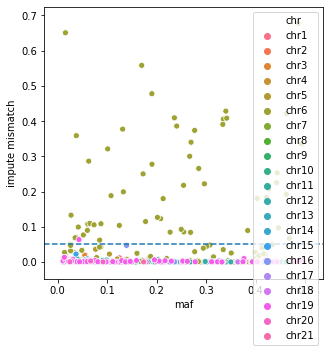

In [20]:
f=plt.figure(figsize=(5,5))
sns.scatterplot(x="maf", y="impute mismatch", hue="chr",data=df)
plt.axhline(0.05, ls='--')
plt.savefig('../plots/icb-trial-imputation-quality.pdf')

## Exclude SNPs with mismatch > 5%

In [21]:
excluded_snps=df[df["impute mismatch"]>0.05]["snps"].tolist()

In [22]:
excluded_snps=excluded_snps+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in excluded_snps]

In [23]:
pd.DataFrame({"snps":excluded_snps}).to_csv("../data/high.mismatch.snps.txt",header=None,sep="\t",index=None)